# SImple Change Detection using Python, TERN web services and Google Earth Engine


<table border="1" cellpadding="1" cellspacing="1" style="width:100%;">
	<tbody>
		<tr>
			<td style="text-align: center;"><img alt="" src="https://camo.githubusercontent.com/55e376c1d172e14591d784aa853ac8c6210f786a/687474703a2f2f726f626572747764656d707365792e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031352f31302f646f636b65722d707974686f6e2e706e67" style="width: 300px; height: 225px;" /></td>
			<td style="text-align: center;"><img alt="" src="http://www.emast.org.au/wp-content/uploads/2014/08/TERN-Logo-250pix.png" style="width: 250px; height: 225px;" /></td>
			<td style="text-align: center;"><img alt="" src="http://www.whizzbangstudios.com/WhizzbangStudios/media/StudioTour/google-earth-engine.jpg?ext=.jpg" style="width: 400px; height: 225px;" /></td>
		</tr>
	</tbody>
</table>


## Abstract

Will your research use a time series of satellite images for change detection? 
Do you want to see Python and Jupyter Notebook in action? 

This notebook demonstrates using Python and Jupyter Notebooks to access a time-series of Landsat images via TERN web services and the Google Earth Engine and to detect changes over time.

## Presentation Outline

For these examples I'll be using a [Jupyter Notebook](http://jupyter.org/) with code in Python.
 - The [Jupyter Notebook](http://jupyter.org/) is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and explanatory text.
  - Uses include: data cleaning and transformation, numerical simulation, statistical modeling, machine learning and much more.
  - The Notebook has support for over 40 programming languages, including those popular in Data Science such as Python, R, Julia and Scala.  
  - Notebooks can be shared with others using tools like email, Dropbox, [GitHub](https://github.com/AusCover/ml-biomass/blob/master/ml-biomass.ipynb) and the Jupyter Notebook Viewer. 
 - If you've never used Jupyter Notebooks before, I highly recommend installing [Anaconda](https://www.continuum.io/downloads)
 - _As an aside, many of the packages used by JRSRP and partners, such as [RIOS](http://rioshome.org/), [RSGISLIB](http://www.rsgislib.org/) and [PyLidar](http://pylidar.org/) can be installed into this environment from the [OSGEO Conda index](https://conda.anaconda.org/osgeo)_

This notebook will outline some simple online interaction with some of the **JRSRP Landsat seasonal mosaics**. We'll treat the data hosted on http://qld.auscover.org.au as files and use the [RasterIO](https://www.mapbox.com/blog/rasterio-announce/) package to interact with the data and undertake some typical remote sensing tasks. Finally we'll build a simple example to extract and analyse a time series of imagery across an agricultural research property in the Burdekin (from ~5 TB of raster data hosted online).


## My setup

#### The biggest impact on data science right now is not coming from a new algorithm or statistical method. It’s coming from Docker containers.   
Containers solve a bunch of tough problems simultaneously: 
* they make it easy to use libraries with complicated setups;
* they make your output reproducible;
* they make it easier to share your work;
* they can take the pain out of the Python data science stack.

This Notebook is using my [Remote Sensing Data Science Stack](https://hub.docker.com/r/petescarth/datascience-rs/)  
  
To run this container as a Python Notebook, use:
`docker run -i -t 
    -v /mnt/data/satellite:/home/jovyan/work 
    -p 7004:8888 
    -t petescarth/datascience-rs start-notebook.sh 
    --NotebookApp.password='sha1:d7527ff31fdf:4002d083d9f874d2ccb74c5d423465571aad21d0'
    --NotebookApp.iopub_data_rate_limit=10000000
`
### Lets try some simple notebook commands like:
```
1+1
print('Hello World')

! df -h

%%time
sum(range(100000000))
```

In [49]:
#Import all the modules we'll need later on
%matplotlib inline
import numpy as np
import datetime
import matplotlib.pyplot as plt

import pyproj
import rasterio
import rasterio.features
import folium



import ee
from IPython import display

## Connect to the TERN AusCover Data
The data on TERN are pushed seasonally from DSITI and now cover all of Australia  
They are mosaiced per state, and then a script on the server produces [gdal virtual mosaics with national extent](http://qld.auscover.org.au/public/data/landsat/seasonal_fractional_cover/ground_cover/aus/)  
These are setup with internal curl links so they work over http requests. e.g.:
```
    <ComplexSource>
      <SourceFilename relativeToVRT="0">/vsicurl/http://qld.auscover.org.au/public/data/landsat/seasonal_fractional_cover/ground_cover/nt/lztmre_nt_m198912199002_dixa2.tif</SourceFilename>
      <SourceBand>1</SourceBand>
      <SourceProperties RasterXSize="45703" RasterYSize="60166" DataType="Byte" BlockXSize="256" BlockYSize="256" />
      <SrcRect xOff="0" yOff="0" xSize="45703" ySize="60166" />
      <DstRect xOff="46604" yOff="9010" xSize="45703" ySize="60166" />
      <NODATA>0</NODATA>
    </ComplexSource>

```

In [2]:
# The paths to the Australian Seasonal Landsat Mosaics on the Queensland RDSI Node
refDataPath = '/vsicurl/http://qld.auscover.org.au/public/data/landsat/surface_reflectance/aus/l8olre_aus_m201609201611_dbia2.vrt'

# Open the  surface reflectance data using rasterio (Could also use GDAL or RIOS or rsgislib etc)
refDataSet = rasterio.open(refDataPath)

# The dataset object contains metadata about the raster data
print("Bands:\t ", refDataSet.count)
print("Height:\t ", refDataSet.height)
print("Width:\t ", refDataSet.width)
print("Number of MegaPixels:\t ", refDataSet.height*refDataSet.width/1e6,0)
print("BoundingBox: ", refDataSet.bounds)
print("CRS:\t ", refDataSet.crs)

('Bands:\t ', 6)
('Height:\t ', 135159)
('Width:\t ', 141481)
('Number of MegaPixels:\t ', 19122.430479, 0)
('BoundingBox: ', BoundingBox(left=-1944645.0, bottom=-4910195.0, right=2299785.0, top=-855425.0))
('CRS:\t ', CRS({u'lon_0': 132, u'ellps': u'GRS80', u'y_0': 0, u'no_defs': True, u'proj': u'aea', u'x_0': 0, u'units': u'm', u'towgs84': u'0,0,0,0,0,0,0', u'lat_2': -36, u'lat_1': -18, u'lat_0': 0}))


### Reading in a data subset from the remote file system

 - First we compute the area we want to extract from the image
 - Then we pull the data subset from the server
 - In all these examples, **subsets are extracted without having to read the entire file** so you only pull the data you are working with back to your browser. In the case of this example, the (compressed) file is 18GB in size but we just read the portion we want so the subset is available in under a second.
 
 #### Displaying a RGB Image

 - Like any remote sensing package, we have to stretch the data into 8 bit space and set up an informative band combination.
 - For more info on common band combinations: http://landsat.usgs.gov/L8_band_combos.php


Data extract shape: (3, 667, 1333), dtype: int16


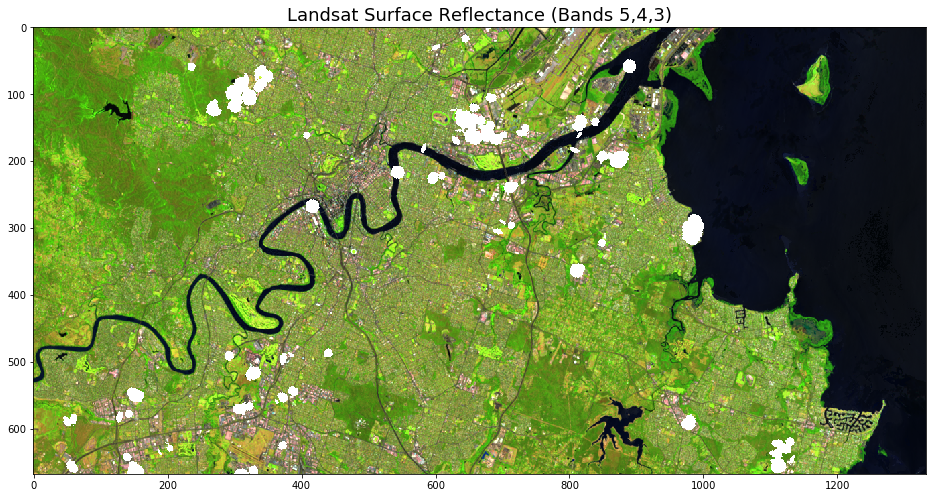

In [3]:
# This takes a subset over an AOI with the bounding box in EPSG:3577 (Australian Albers)
# Brisbane
topLeft = (2030000,-3140000)
bottomRight = (2070000,-3160000)

# Compute the image coordinates from the real world coordinates using an inverse transform
y1, x1 =  ~refDataSet.transform * topLeft
y2, x2 =  ~refDataSet.transform * bottomRight

# Read in the SWIR, NIR and Red bands within the specified bounding box
refDataSubset = refDataSet.read([5,4,3], window=((int(x1),int(x2)), (int(y1),int(y2))))

# Print some information on the subset
print('Data extract shape: {0}, dtype: {1}'.format(refDataSubset.shape, refDataSubset.dtype))

# Stretch and scale the data from 0 to 255 as an unsigned 8 bit integer for display
refDataSubsetScaled=np.clip(refDataSubset / 4000.0 * 255.0, 0, 255).astype('uint8')

# Plot the image using matplotlib
plt.figure(figsize=(16,10))

# Rearrange the axes so that it works with matplotlib that likes BIP not BSQ data
plt.imshow(np.rollaxis(refDataSubsetScaled,0,3))

# Add a title to the plot
plt.title('Landsat Surface Reflectance (Bands 5,4,3)', fontsize=18)

### Handle projections
One of the constants of spatial data is that it's often projected. In this case, the projection used is Australian Albers or EPSG:3577.  
It's convenient to specify extract areas in Latitude/Longitude so we define a function to do the transform for us.

In [4]:
# Function to convert geographical to projected coordinates
def ll2albers(x,y):
    inProj = pyproj.Proj(init='epsg:4326')
    outProj = pyproj.Proj(init='epsg:3577')
    return pyproj.transform(inProj,outProj,x,y)


### Work out where we are in the world
It's useful to define a map to get coordinates from, and to plot up bounding boxes to check what we're looking at.  
This map used the google hybrid layer.

In [5]:
# Utility Query Mapping function
# Takes a topLeft and bottomRight Tuple
def mapQuery(topLeft, bottomRight):
    map_hybrid = folium.Map(
        location=[np.mean([topLeft[1],bottomRight[1]]), np.mean([topLeft[0],bottomRight[0]])],
        zoom_start=12, 
        tiles=" http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",
        attr="Google")
    map_hybrid.add_children(folium.features.PolyLine(
        locations=[
          (topLeft[1],topLeft[0]),
          (bottomRight[1],topLeft[0]),
          (bottomRight[1],bottomRight[0]),
          (topLeft[1],bottomRight[0]),
          (topLeft[1],topLeft[0])],
        color='red', opacity=0.5))
    map_hybrid.add_children(folium.features.LatLngPopup())
    return map_hybrid


## Have a look at an area where there might have been change
Here we extract the data over an area where there is active CSG activity

In [6]:
mapQuery((150.3727,-26.9819),(150.4963,-27.0767))

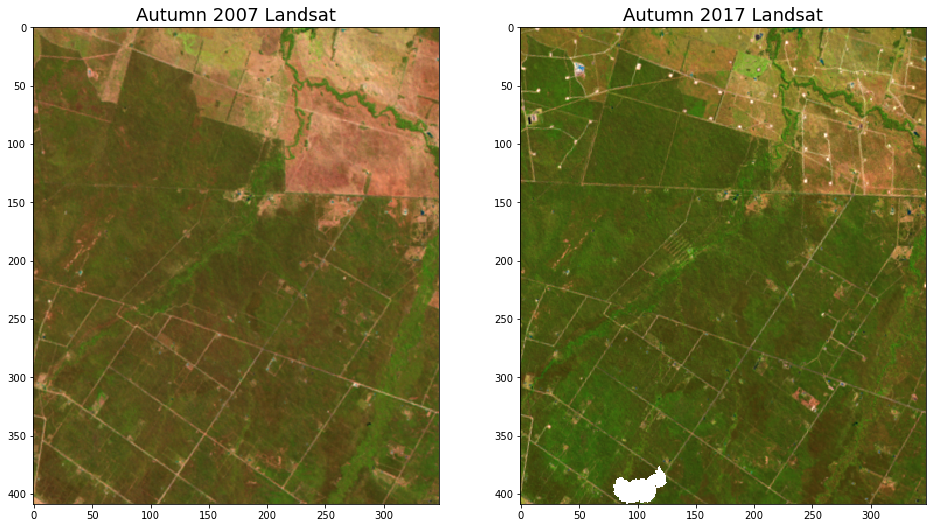

In [7]:
# This is a subset west of Tara where Coal Seam Gas development has been happening
topLeft = ll2albers(150.3727,-26.9819)
bottomRight = ll2albers(150.4963,-27.0767)


# The paths to the 2007 Australian Seasonal Landsat Mosaics on the Queensland RDSI Node
date1DataPath = '/vsicurl/http://qld.auscover.org.au/public/data/landsat/surface_reflectance/aus/lztmre_aus_m200703200705_dbia2.vrt'

# The paths to the 2017 Australian Seasonal Landsat Mosaics on the Queensland RDSI Node
date2DataPath = '/vsicurl/http://qld.auscover.org.au/public/data/landsat/surface_reflectance/aus/l8olre_aus_m201703201705_dbia2.vrt'

# Compute the image coordinates from the real world coordinates using an inverse transform
y1, x1 =  ~refDataSet.transform * topLeft
y2, x2 =  ~refDataSet.transform * bottomRight

# Read in the SWIR, NIR and Red bands within the specified bounding box
date1DataSubset = rasterio.open(date1DataPath).read([5,4,3], window=((int(x1),int(x2)), (int(y1),int(y2))))
date2DataSubset = rasterio.open(date2DataPath).read([5,4,3], window=((int(x1),int(x2)), (int(y1),int(y2))))

# Setup the plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))

# Rearrange and scale the data
ax1.imshow(np.rollaxis(np.clip(date1DataSubset / 5000.0 * 255.0, 0, 255).astype('uint8'),0,3), aspect=1)
ax2.imshow(np.rollaxis(np.clip(date2DataSubset / 5000.0 * 255.0, 0, 255).astype('uint8'),0,3), aspect=1)

# Add some titles
ax1.set_title('Autumn 2007 Landsat', fontsize=18)
ax2.set_title('Autumn 2017 Landsat', fontsize=18)




### Computing NDVI from the extracted Subsets
The Normalised Differencing Vegetation Index is widly used as an indicator of vegetation vigour and density.  
 - Everyone uses NDVI as a 'Hello World" remote sensing example so I will as well.
 - Note that these data use 32767 as a nodata value so we need to mask these out from the calculation.

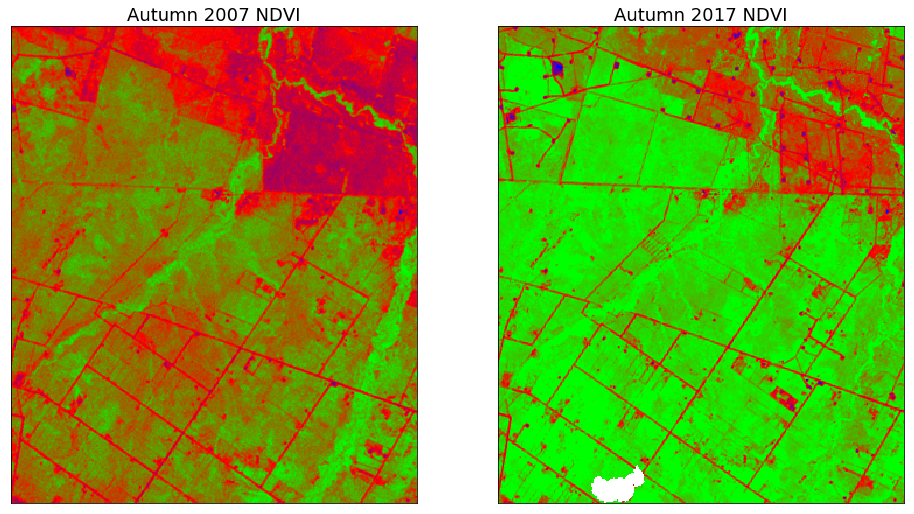

In [8]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Create a function to compute the ndvi from the red and NIR bands
def makeNDVI(b4,b3):
    # Calculate NDVI
    ndvi = (b4.astype(float) - b3.astype(float)) / (b4.astype(float) + b3.astype(float))
    # Make the NoData values NaN so they get masked from the analysis
    ndvi[b4 == 32767] = np.nan
    return ndvi
    
# Use the function to produce NDVI images
# Watch the band ordering - remember we've read in bands 5,4,3
date1NDVI = makeNDVI(date1DataSubset[1],date1DataSubset[2])
date2NDVI = makeNDVI(date2DataSubset[1],date2DataSubset[2])


# Setup the plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))

# Rearrange and scale the data
ax1.imshow(date1NDVI, cmap='brg',clim=(-0.1,0.7))
ax2.imshow(date2NDVI, cmap='brg',clim=(-0.1,0.7))

# Add some titles
ax1.set_title('Autumn 2007 NDVI', fontsize=18)
ax2.set_title('Autumn 2017 NDVI', fontsize=18)

# Remove the axis labels for clarity
ax1.yaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax1.xaxis.set_visible(False)
ax2.xaxis.set_visible(False)


## NDVI Change analysis
Now we have a look at how the values have changed in this 10 year period.  
To do this we simply subtract the two dates. Initially we plot a histogram to look at the spread of values.  
This is because differences and NDVI Are due to many things other than change. Primarily the largest difference here is due to climatic effects. It was much wetter at the start of this year than it was in the start of 2007 and so overall there is a general decrease in NDVI between these two time periods. However certain areas of change are obvious as well. There are more watering points (indicated by very low NDVI values) and there is more coal seam gas infrastructure.  
  
We can undertake a very simple normalisation by simply standardising each era so that all change is centred around zero. This makes the resulting change image slightly easier to interpret.

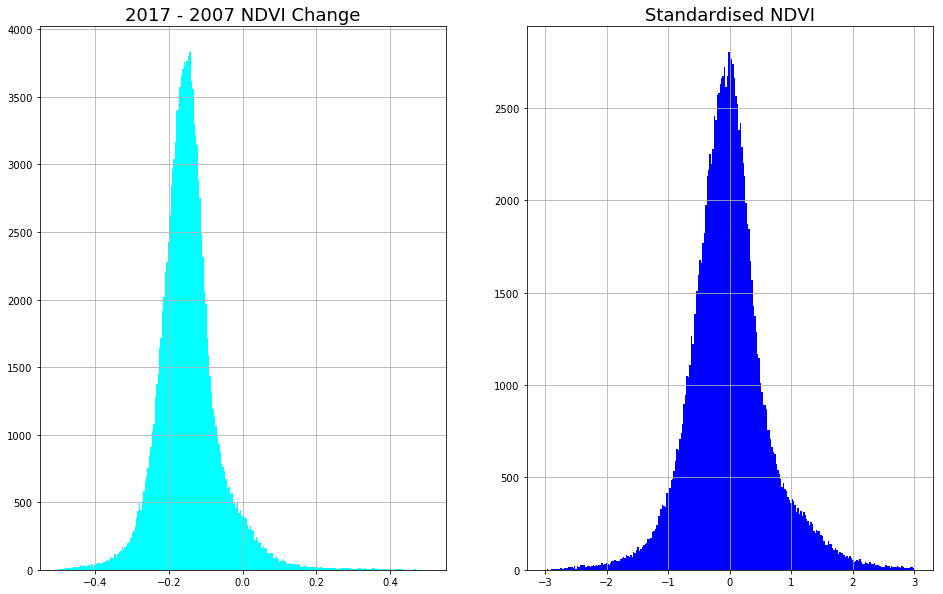

In [9]:
# Compute the NDVI change between the dates
ndviChange = date1NDVI - date2NDVI

# Standardise the change
ndviChangeNorm = ((date1NDVI - np.nanmean(date1NDVI)) / np.nanstd(date1NDVI)) - \
                 ((date2NDVI - np.nanmean(date2NDVI)) / np.nanstd(date2NDVI))



# Setup the plots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))

# Rearrange and scale the data
ax1.hist(ndviChange.ravel(), bins=256, range=(-0.5, 0.5),color = "cyan")
ax2.hist(ndviChangeNorm.ravel(), bins=256, range=(-3, 3),color = "blue")

# Add some titles
ax1.set_title('2017 - 2007 NDVI Change', fontsize=18)
ax2.set_title('Standardised NDVI', fontsize=18)

# Add some grids
ax1.grid()
ax2.grid()

### Show the change
Now we can make a image of the change in NDVI between the two dates. In a colour map we have selected below red indicates a decrease between the dates, green indicates an increase between the dates.

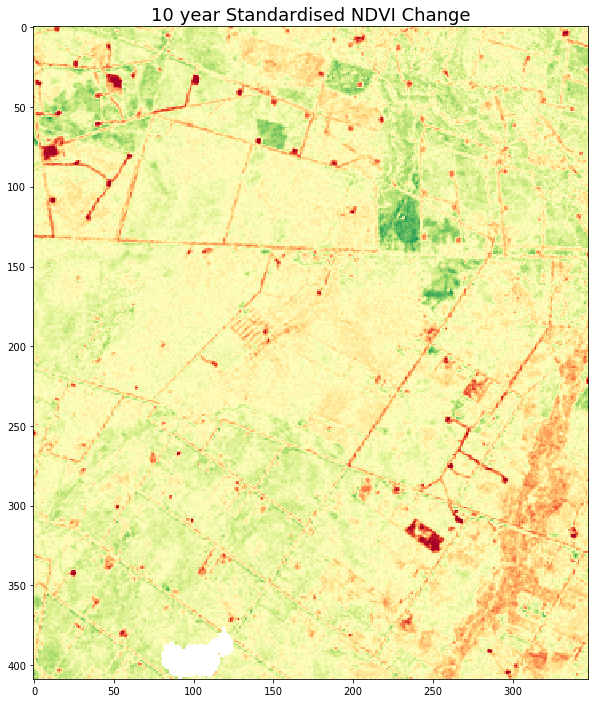

In [10]:
plt.figure(figsize=(12,12))
plt.imshow(ndviChangeNorm, cmap='RdYlGn_r',clim=(-3.8,3.8))
# Add a title to the plot
plt.title('10 year Standardised NDVI Change', fontsize=18)

## Examine what's happening in that greening area...
Your notice that aside from areas of infrastructure that have been put in and a small patch of clearing in the south-east corner there is an area of significant greening up in the north-east.  

In [11]:
# Check where we are
mapQuery((150.4436,-27.0037),(150.4458,-27.0062))

### Extract and plot the time series of green
To see what's happening here we can plot a time series of the green fraction. The green fraction is another product hosted by TERN and is one band of the [fractional cover](http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Seasonal+Fractional+Cover) product.  

We also fit a trend line to the green data over the period of interest.  

As a convienence, The server hosts time series stacks of cover fractions in virtual files that make pulling out time series a breeze. But you could also iterate over all the individual bands without too many problems.

In [ ]:
# This is a subset over the possible regrowth area
topLeft = ll2albers(150.4436,-27.0037)
bottomRight = ll2albers(150.4458,-27.0062)

# The paths to the Green cover timeseries on the Queensland RDSI Node
greenDataPath = '/vsicurl/http://qld.auscover.org.au/public/data/landsat/seasonal_fractional_cover/fractional_cover/aus/lztmre_aus_s198712201705_dima2_green.vrt'

# Open the green data
greenDataSet = rasterio.open(greenDataPath)

# Compute the image coordinates from the real world coordinates using an inverse transform
y1, x1 =  ~greenDataSet.transform * topLeft
y2, x2 =  ~greenDataSet.transform * bottomRight

# Read in the entire green cover timeseries within the specified bounding box
greenDataSubset = greenDataSet.read(window=((int(x1),int(x2)), (int(y1),int(y2)))).astype('float')

# Print some information on the subset
print('Data extract shape: {0}, dtype: {1}'.format(greenDataSubset.shape, greenDataSubset.dtype))

# Mask the nodata values
greenDataSubset[np.where(greenDataSubset==greenDataSet.nodata)]=np.nan

# Compute the mean groundcover per slice
gcTimeSeries = np.nanmean(np.reshape(greenDataSubset,(greenDataSet.count,-1)),axis=1) - 100

# Date Calculation. You could also get from the images
seasonalDates = [datetime.datetime(1987, 12, 1, 0, 0) +
            datetime.timedelta(days=365.25/4*x)
            for x in range(greenDataSet.count)]


# We're only interested in the period from 2007 onwards, so we subset the array
# The 76th season is Autumn 2007
seasonalDates = seasonalDates[76:]
gcTimeSeries = gcTimeSeries[76:]

# Fit a trendline to the series to check the trend
# First define the x values. Could be seconds but here we use seasons
xVal = np.arange(len(gcTimeSeries))
# Work out where the nodata is so we can mask in the fitting
goodData = np.isfinite(gcTimeSeries)
# Fit the good data using a one degree polynomial
greenFun = np.poly1d(np.polyfit(xVal[goodData],gcTimeSeries[goodData],1))
print("Trend Function is %s" % str(greenFun))
# Evaluate the polynomial to retrieve the function values
greenFit = greenFun(xVal)


# Setup the figure
fig = plt.figure(figsize=(16,8))

# Plot the points from 2007 onwards
plt.plot(seasonalDates, gcTimeSeries, 'g-',linewidth=3)
plt.plot(seasonalDates, greenFit, 'r:',linewidth=2)

# Add annotation to the plot
plt.xlabel('Season Start Date')
plt.ylabel('Green cover (%)')
plt.title('Green cover across regrowth site', fontsize=16)
plt.grid(True)




## Earth Engine Example
This connects to the [Google Earth Engine](https://earthengine.google.com/)  
You need an Earth Engine account to run these examples.

In [50]:
ee.Initialize()

### Display an individual scene
This is a recent Landsat 8 scene

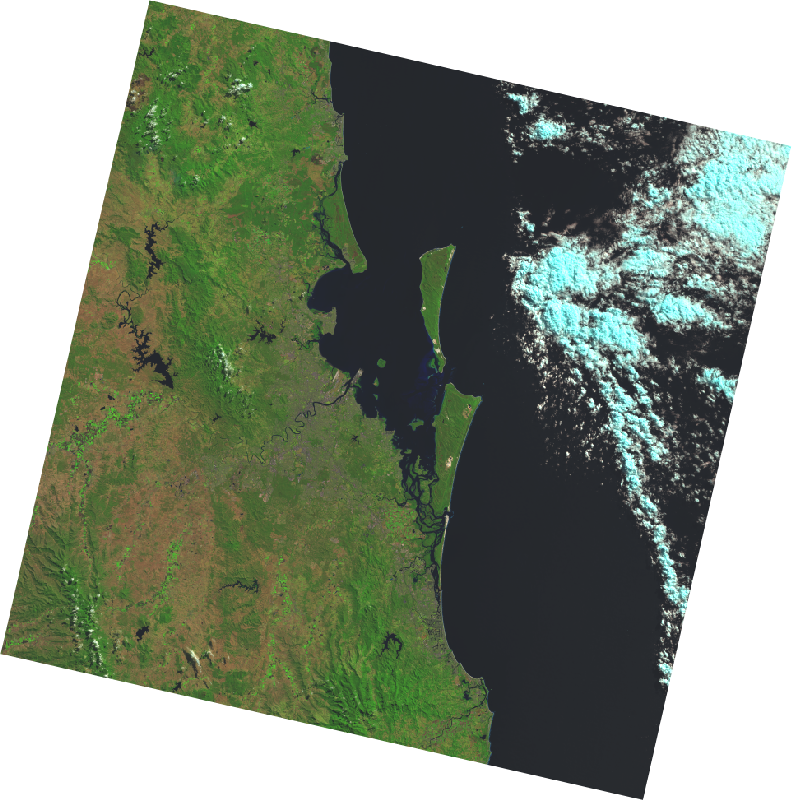

In [51]:
input_image = ee.Image('LANDSAT/LC08/C01/T1_RT/LC08_089079_20170828')


# Helper function to make it easier to print thumbnails of Earth Engine images
def print_image(image):
  display.display(display.Image(ee.data.getThumbnail({
      'image': image.serialize(),
      'dimensions': '800',
  })))


# Show the image
print_image(input_image.visualize(
    bands=['B6', 'B5', 'B4'],
    min=1000,
    max=30000,
))


### Make a "Slippy Map" Interface
The functions below allow you to make slippy maps a little like the Earth Engine Playground

In [52]:
def folium_gee_map(image,vis_params=None,folium_kwargs={}):
    """
    Function to view Google Earth Engine tile layer as a Folium map.
    
    Parameters
    ----------
    image : Google Earth Engine Image.
    vis_params : Dict with visualization parameters.
    folium_kwargs : Keyword args for Folium Map.
    """
    
    # Get the MapID and Token after applying parameters
    image_info = image.getMapId(vis_params)
    mapid = image_info['mapid']
    token = image_info['token']
    folium_kwargs['attr'] = ('Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a> ')
    folium_kwargs['tiles'] = "https://earthengine.googleapis.com/map/%s/{z}/{x}/{y}?token=%s"%(mapid,token)
    
    return folium.Map(**folium_kwargs)

def folium_gee_layer(folium_map,image,vis_params=None,folium_kwargs={}):
    """
    Function to add Google Earth Engine tile layer as a Folium layer.
    
    Parameters
    ----------
    folium_map : Folium map to add tile to.
    image : Google Earth Engine Image.
    vis_params : Dict with visualization parameters.
    folium_kwargs : Keyword args for Folium Map.
    """
    
    # Get the MapID and Token after applying parameters
    image_info = image.getMapId(vis_params)
    mapid = image_info['mapid']
    token = image_info['token']
    folium_kwargs['attr'] = ('Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a> ')
    folium_kwargs['tiles'] = "https://earthengine.googleapis.com/map/%s/{z}/{x}/{y}?token=%s"%(mapid,token)
    
    layer = folium.TileLayer(**folium_kwargs)
    layer.add_to(folium_map)

### Displaying some layers
Let's Try our functions out with a few layers

In [56]:
def NDVI(image):
  """A function to compute NDVI."""
  return image.expression('float(b("B5") - b("B4")) / (b("B5") + b("B4"))')



# Get an area to look at
lat = -27
lon = 153
zoom_start=10

# Open Street Map Base
fmap = folium.Map(location=[lat, lon], tiles="OpenStreetMap", zoom_start=zoom_start)

# Add SRTM Terrain Layer
image = ee.Image('srtm90_v4')
vis_params = {'min':0.0, 'max':2000, 'palette':'888800,0000AA,00AA00,00FF00,FF0000,FFFFFF'}
folium_gee_layer(fmap,image,vis_params=vis_params,folium_kwargs={'overlay':True,'name':'SRTM'})

# Create a reference to the image collection
l8 = ee.ImageCollection('LANDSAT/LC8_SR')

# Add the latest-on-top image to the map
folium_gee_layer(fmap,l8,{'min': 0, 'max':4000,
                          'bands':'B6,B5,B4'},
                 folium_kwargs={'overlay':True,'name':'Latest Landsat 8 SR'})

# Filter the collection down to a year
filtered2016 = l8.filterDate('2016-01-01', '2016-12-31');

# Use the median reducer for all data in the year
l8_2016 = filtered2016.median()

folium_gee_layer(fmap,l8_2016,{'min': 0, 'max':4000,
                               'bands':'B6,B5,B4'},
                 folium_kwargs={'overlay':True,'name':'Median Landsat 8 SR'})

fmap.add_child(folium.LayerControl())
fmap.add_children(folium.features.LatLngPopup())

In [70]:
# Get an area to look at
lat = -27.4045
lon = 151.0665
zoom_start=13

# Open Street Map Base
fmap = folium.Map(location=[lat, lon], tiles="OpenStreetMap", zoom_start=zoom_start)

# Create a reference to the image collection
l8 = ee.ImageCollection('LANDSAT/LC8_SR')

# Filter the collection down to a year
l8_2016 = l8.filterDate('2016-01-01', '2016-12-31').median();
l8_2014 = l8.filterDate('2014-01-01', '2014-12-31').median();


# Compute the NDVIs using one of the GEE expression languages
l8_2016_NDVI = l8_2016.expression('float(b("B5") - b("B4")) / (b("B5") + b("B4"))')
l8_2014_NDVI = l8_2014.expression('float(b("B5") - b("B4")) / (b("B5") + b("B4"))')

l8_NDVI_diff = l8_2014_NDVI.subtract(l8_2016_NDVI)


# Add the 2014 Layer
folium_gee_layer(fmap,l8_2014,{'min': 0, 'max':4000,
                               'bands':'B6,B5,B4'},
                 folium_kwargs={'overlay':True,'name':'2014 Landsat 8 SR'})
# Add the 2016 Layer
folium_gee_layer(fmap,l8_2016,{'min': 0, 'max':4000,
                               'bands':'B6,B5,B4'},
                 folium_kwargs={'overlay':True,'name':'2016 Landsat 8 SR'})

# Add the NDVI Difference Layer
folium_gee_layer(fmap,l8_NDVI_diff ,{'min':-0.5, 'max':0.5,
                                     'palette':'00FF00,888888,FF0000'},
                 folium_kwargs={'overlay':True,'name':'NDVI Difference'})

fmap.add_child(folium.LayerControl())
fmap.add_children(folium.features.LatLngPopup())

### Use the Earth Engine to calculate the closest water to a point
This uses the full Landsat 8 timeseries and the NDWI to estimate permanent water and then find the closest polygon

In [ ]:
%%time

def eeClosestWater(lon,lat,buf):
    
    #Initialise the Earth Engine
    ee.Initialize()
    
    # Build the area we are interested in
    thePoint  = ee.Geometry.Point(lon, lat)
    bufferPoint = thePoint.buffer(buf);
    
    # Get a median NDVI Image for the last year
    collection8 = ee.ImageCollection('LANDSAT/LC8_L1T_TOA')
    
    # Rough Water Index
    waterIndex = collection8.map(lambda img:img.normalizedDifference (["B4","B6"]))
    
    # Eyeballed Thresholds. Your milage may vary with 0.2
    isWater = waterIndex.map(lambda img:img.gt(0.20))
    notWater = waterIndex.map(lambda img:img.lte(0.20))
    
    # Work out the percentage of time water was seen in a pixel
    waterCounts = isWater.sum().clip(bufferPoint);
    notWaterCounts = notWater.sum().clip(bufferPoint);
    imageCount = waterCounts.add(notWaterCounts);
    waterProb = waterCounts.divide(imageCount);
    
    # Another eyeballed threshold for deciding if water is there enough
    goodWater  = waterProb.gt(0.20).mask(waterProb.gt(0.20));
    
    # Find the centroids of the detected water. To edge of polygon would be better
    waterPolys = goodWater.reduceToVectors(ee.Reducer.countEvery(), bufferPoint, 30, "centroid", True, "label", "EPSG:4326");
    
    # Compute the distance between the point and all the centroids
    centroidDistance =waterPolys.map(lambda p:ee.Feature(p).set('distance',thePoint.distance(p.geometry())))
    
    # Pick the closest one to return 
    closestWaterCoord = centroidDistance.limit(1,"distance",True).geometry().getInfo()['coordinates']

    return closestWaterCoord


print(eeClosestWater(143.0295967,-27.4952757, 5000 ))